# Modeling and Predicting Chart Difficulties with Machine Learning

Svitlana Glibova,  
January 2021 Flatiron Data Science Cohort

## Business Understanding
### Domain Introduction
Stepmania is an open-source software designed to support many styles of rhythm
game play, but one of its most widely-used formats is for 4-panel “dance games”
(well-known “dance game” examples are Dance Dance Revolution and In The Groove,
but these are specifically-licensed games by Konami and Roxor). The software was
released in 2001 and has since been updated through version 5.3 - the concept behind
this software is to allow players to play a “DDR-like” game with virtually boundless
customizations, including custom charts (arrow patterns for songs).  

### Business Problem
The problem that I aim to solve is using exploratory data analysis and statistical learning
to help establish a standardization for song chart difficulty ratings based on various
features of the chart, for example BPM, duration, and quantity of technical elements.

### Motivation  
While there are many respectable step-artists with expertise in their domains, there has
not been an official and standardized rating system for song difficulties - it is not
uncommon to see players in conversation over whether a song should be “re-rated”
due to various features of its chart. Creating a method of standardization will help
examine which features are the most important in determining difficulty and help
step-artists remove the intuitive/guesswork element from rating their own charts.
The community of rhythm game players is surprisingly large and the amount of
dedication that this community has poured into creating an open-source rendition of
rhythm games is incredible. This software is free and is used for tournament play and
for writing charts and is a staple to any outside-of-arcade dance game player, and is
sometimes employed in small, local arcades as well.

## A Brief Overview of StepMania and "Dance Games"

## Data Understanding

### Data Collection 
[itgpacks.com](www.itgpacks.com) is a community-maintained spreadsheet containing the majority of song packs released in the last five years. The majority of this data came from here, with the exception of a few packs downloaded from other sources.   

The data is extracted from each individual song file using a parser written in Python to collect the features used for EDA and predictive modeling. A huge, huge, huge thank you to Tim Murphy, a friend and dance game player, for writing the code for this parser. You can check out their [GitHub here.](https://github.com/JaceTSM/).  

### Chart Features
See [this link](data/feature_dictionary.txt) for a full explanation of each feature that was extracted from the song files.

### Why is the data being split this way?  

With some domain understanding, I thought that it would be important to distinguish between 'stamina' and 'tech' data. 

*'Tech'* refers to songs that are perhaps more technically challenging, requiring the player to unpack more complex arrow patterns and to generally have more lateral movement. The song lengths are on the shorter side relative to songs found across both styles.  


*'Stamina'* song difficulties and lengths can range much higher, therefore the outliers are going to be on a different scale than those of tech. With much longer songs, the patterns are less complex but require much more consolidation of movement from the player and test endurance.  

Below, notice the large differences between the mean and max differences of features between the datasets.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, accuracy_score, f1_score,\
                            roc_curve, auc, classification_report, log_loss, mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA


from xgboost import XGBClassifier, XGBRegressor


import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
##display all dataframe columns
pd.set_option('display.max_columns', None)

tech = pd.read_csv('data/not_stam.csv')
stam = pd.read_csv('data/stam.csv')

In [6]:
from src.data_cleaning import data_cleaner

## Exploratory Data Analysis

To see a full breakdown of data exploration, filling NaN values, and methods for removing outliers, visit the [EDA Notebook]('eda_notebook.ipynb').  

To preserve the signal of the data, the data cleaning function takes in a dataframe and a Boolean value for whether it is stamina data or not and preserves data within the 90th percentile for the following features:   
`step_count` (97.5% for stamina data due to stamina having a much broader distribution of steps)    
`bpm_weighted_avg`    
`bpm_change_count`  
`song_nps`   

For technical data, the following features are removed due to them very infrequently occurring in the dataset, if at all.  
For stamina data, any NaN value is replaced with the median to help maintain the distribution.  
`stream_count`  
`stream_size_max`   
`stream_size_avg`  
`stream_size_std`  
`break_count`  
`break_size_max`  
`break_size_avg`   
`break_total`  
`break_size_std`  

A few other outliers were addressed, such as removing any song labelled difficulty 1 but not 'Beginner', as well as any charts with 'joke' ratings as placed intentionally by the step-artist.

### 'Tech' Data

In [7]:
tech_df = data_cleaner(tech)

Initialized Tech DataFrame with 4808 rows.

Removing outliers and filling NaN values...

The songs in this Tech dataset are up to 164.002 seconds (2.733 minutes) long.
The songs in this Tech dataset have up to 826 steps.
The songs in this Tech dataset have a max bpm weighted average up to 175 bpm.
The songs in this Tech dataset have up to 21 bpm changes.
The songs in this Tech dataset are up to 6.387 NPS.

Returning cleaned Tech DataFrame with 3236 rows and 31 columns.


In [8]:
tech_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,rating
count,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.00000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000,3236.000000
mean,124.939581,375.223733,69.380408,133.446658,146.505247,120.169037,134.462669,1.671508,3.015767,5.533509,3.043281,3.227578,1.327000,3.322468,18.596724,0.125773,0.04759,34.366811,5.962299,2.838690,7.381026,13.055315,3.409147,2.342707,2.948702,0.772868,2.148331,6.582200
std,14.597848,215.282927,12.534894,20.607616,39.719405,31.216151,21.804486,3.725007,1.711568,3.305625,1.726194,1.845572,0.797263,2.091759,19.482935,1.182276,0.84001,34.330774,14.663473,7.772694,7.661243,14.004427,3.927484,3.964406,3.433064,3.835169,4.900897,3.514208
min,16.971412,30.000000,7.000000,58.741500,90.000000,4.250000,47.000000,0.000000,0.270833,0.416667,0.270833,0.000000,0.094991,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,115.200000,183.000000,61.000000,122.097153,125.999992,105.000000,124.999992,0.000000,1.486950,2.666667,1.498501,1.600000,0.662269,1.525000,5.000000,0.000000,0.00000,8.000000,0.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000
50%,124.800000,369.000000,69.000000,130.000000,135.000000,128.000000,130.000000,0.000000,3.012753,5.000000,3.037832,3.216667,1.223296,3.227083,13.000000,0.000000,0.00000,25.000000,0.000000,0.000000,5.000000,9.000000,2.000000,1.000000,2.000000,0.000000,0.000000,7.000000
75%,134.400000,555.250000,76.000000,148.000000,159.000000,140.000000,150.000000,2.000000,4.460403,8.190625,4.498397,4.800000,1.895284,4.875000,27.000000,0.000000,0.00000,52.000000,4.000000,2.000000,11.000000,18.000000,5.000000,3.000000,4.000000,0.000000,1.000000,10.000000
max,164.001545,826.000000,120.000000,175.000000,540.000000,175.000000,228.000000,21.000000,6.375353,34.000000,7.626016,9.250000,7.248217,12.800000,180.000000,32.000000,40.00000,291.000000,211.000000,116.000000,61.000000,145.000000,47.000000,41.000000,25.000000,65.000000,36.000000,14.000000


### 'Stamina' Data

In [9]:
stam_df = data_cleaner(stam, is_stamina = True)

Initialized Stamina DataFrame with 2926 rows.

Removing outliers and filling NaN values...

The songs in this Stamina dataset are up to 7089.862 seconds (118.164 minutes) long.
The songs in this Stamina dataset have up to 5309 steps.
The songs in this Stamina dataset have a max bpm weighted average up to 216.0 bpm.
The songs in this Stamina dataset have up to 4 bpm changes.
The songs in this Stamina dataset are up to 10.873 NPS.

Returning cleaned Stamina DataFrame with 2254 rows and 40 columns.


In [14]:
stam_df.describe()

,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,rating
count,2287.000000,2287.000000,2287.000000,2287.000000,2.287000e+03,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000
mean,261.873897,1727.597726,178.225186,165.005359,5.412749e+03,162.550080,164.909974,0.174464,6.701975,10.505899,6.712772,7.288617,3.006128,8.554097,20.681242,0.110188,0.067337,69.878006,11.190206,3.403148,5.334062,13.106690,3.219502,1.427634,4.286839,0.002624,61.829908,7.782685,23.142545,11.579264,8.044649,8.771316,38.902492,15.870039,104.454307,13.754685,12.228247
std,101.519229,929.899552,69.398979,28.084973,1.448036e+05,31.267703,28.847299,0.704128,2.514109,3.441717,2.512291,3.279981,1.270053,3.928374,30.522231,1.439694,0.580234,76.948321,43.273815,9.208870,9.494364,21.469892,6.255070,3.571405,7.136583,0.051164,58.006429,5.518401,23.145074,14.365454,8.909119,5.512151,26.696221,16.120614,56.500021,12.154812,3.857867
min,61.286375,20.000000,31.000000,76.000000,7.600000e+01,43.500000,76.000000,0.000000,0.106967,0.525000,0.125000,0.000000,0.052933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.235702,2.000000,2.000000,1.000000,3.000000,0.577350,1.000000
25%,192.000000,1047.000000,121.000000,141.081000,1.430000e+02,140.000000,141.081000,0.000000,5.258994,9.200000,5.278708,5.287500,2.210102,5.750000,1.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,4.000000,10.000000,4.500000,4.359395,5.000000,23.000000,7.733333,68.000000,7.550956,11.000000
50%,255.085714,1644.000000,178.000000,174.000000,1.740000e+02,173.000000,174.000000,0.000000,6.979552,11.533333,6.981865,6.675000,3.123474,9.200000,10.000000,0.000000,0.000000,49.000000,0.000000,0.000000,2.000000,5.000000,1.000000,0.000000,2.000000,0.000000,50.000000,6.000000,15.000000,6.392857,4.359395,7.000000,30.000000,9.875000,83.000000,9.633770,13.000000
75%,314.202169,2310.000000,218.000000,180.004000,1.803560e+02,180.000000,180.004000,0.000000,8.473098,12.666667,8.477924,9.545000,3.879434,11.666667,27.000000,0.000000,0.000000,97.500000,3.000000,2.000000,7.000000,17.000000,4.000000,1.000000,5.000000,0.000000,96.000000,9.000000,31.000000,13.430556,9.073772,10.000000,47.000000,18.000000,135.000000,15.754515,15.000000
max,736.363636,5065.000000,477.000000,216.000000,4.000000e+06,216.000000,216.000000,4.000000,11.285106,20.800667,11.285106,17.400000,8.155928,20.500000,289.000000,40.000000,9.000000,641.000000,501.000000,112.000000,108.000000,224.000000,63.000000,50.000000,97.000000,1.000000,303.000000,46.000000,192.000000,168.000000,107.480231,47.000000,236.000000,136.000000,422.000000,161.220346,27.000000


### Visualization of Cleaned DataFrames

In [143]:
from src.visualizer import distribution, scatter_correlation, box_plot, plot_resids

### Technical Dataset

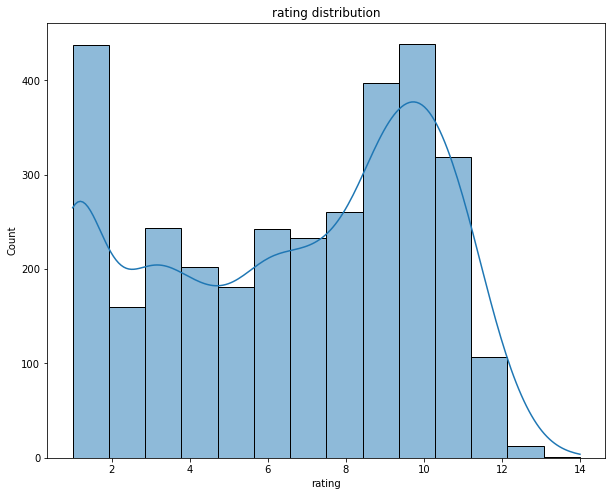

In [87]:
distribution(tech_df, 'rating')

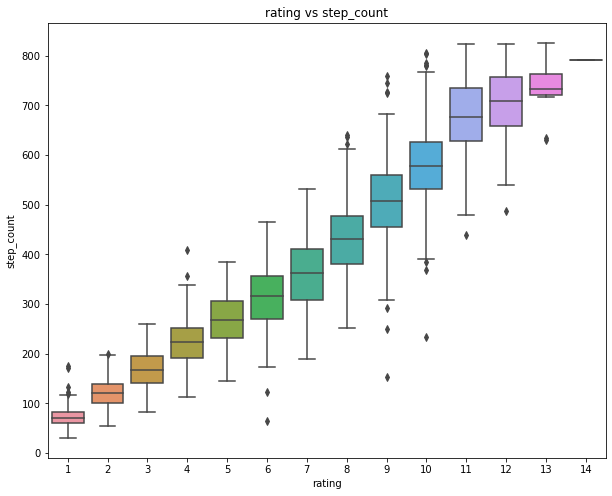

In [88]:
box_plot(tech_df, 'rating')

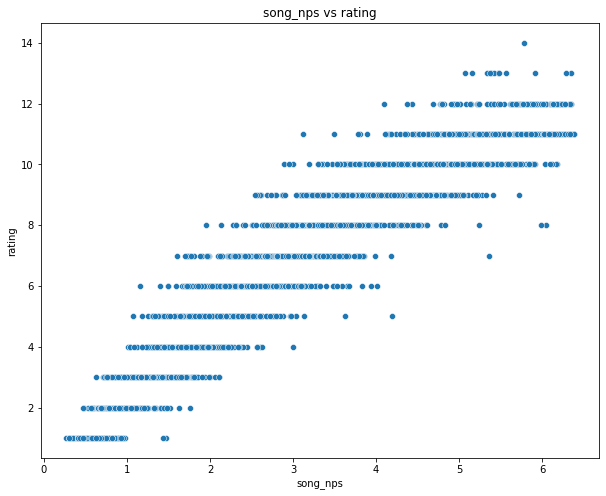

In [89]:
scatter_correlation(tech_df, 'song_nps')

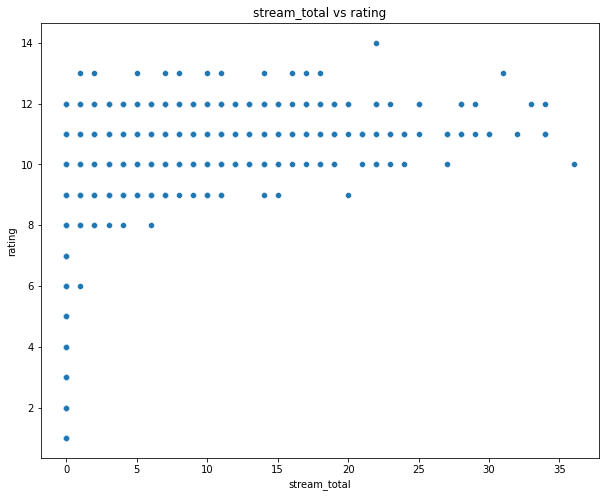

In [90]:
scatter_correlation(tech_df, 'stream_total')

A lot of these features express a linear relationship with the rating, but stream total does have more of a logarithmic curve.

### Stamina Dataset

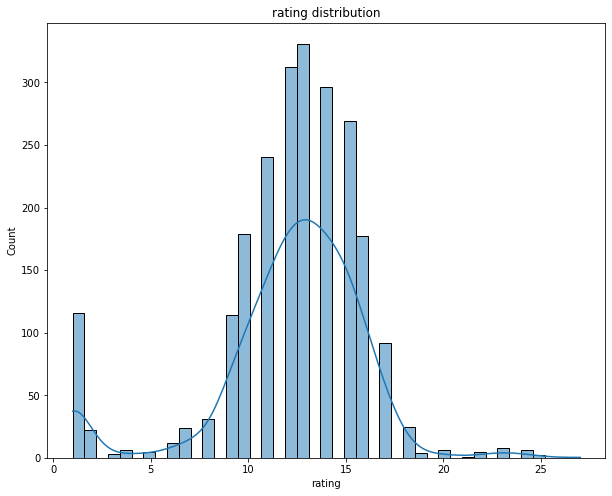

In [91]:
distribution(stam_df, 'rating')

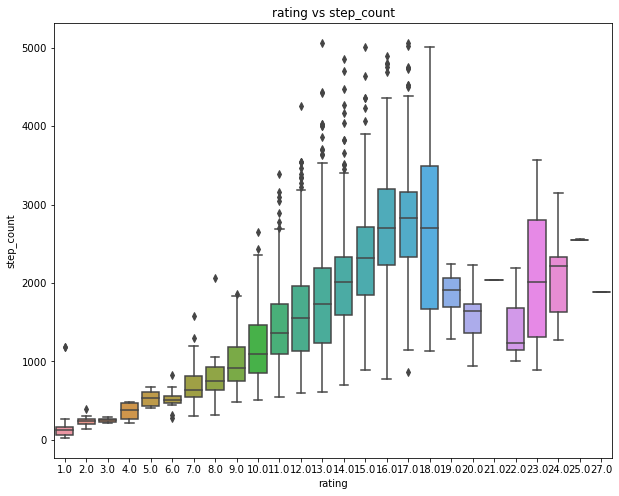

In [92]:
box_plot(stam_df, 'rating')

The upper-level difficulties in the stamina dataset have much fewer songs, hence the odd distribution of step counts. For the sake of training a model on this data, I have selected to keep them in.

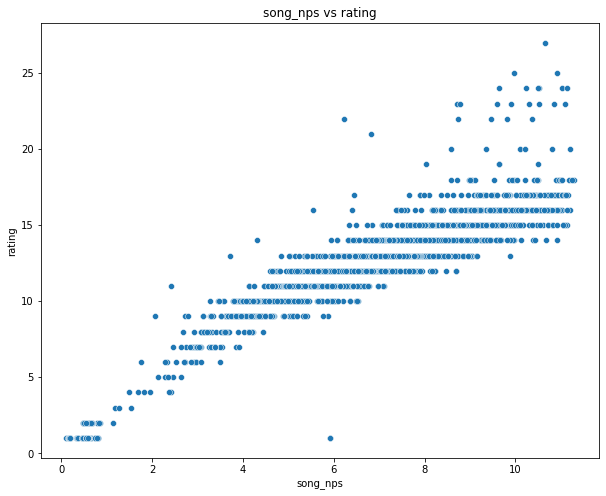

In [93]:
scatter_correlation(stam_df, 'song_nps')

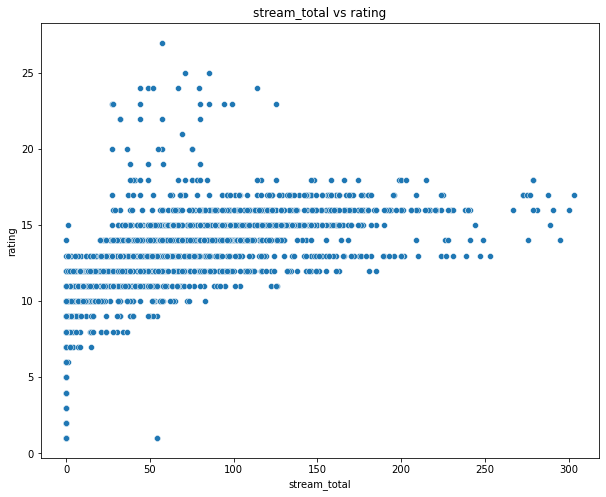

In [94]:
scatter_correlation(stam_df, 'stream_total')

### Feature Engineering

The 'stream_total' feature seemed to have a logarithmic curve in relation to rating, so I created a transformed column for both dataframes to try to capture that.

In [95]:
tech_df['stream_log_transform'] = np.where(tech_df['stream_total'] > 0, np.log(tech_df['stream_total']), tech_df['stream_total'])
stam_df['stream_log_transform'] = np.where(stam_df['stream_total'] > 0, np.log(stam_df['stream_total']), stam_df['stream_total'])

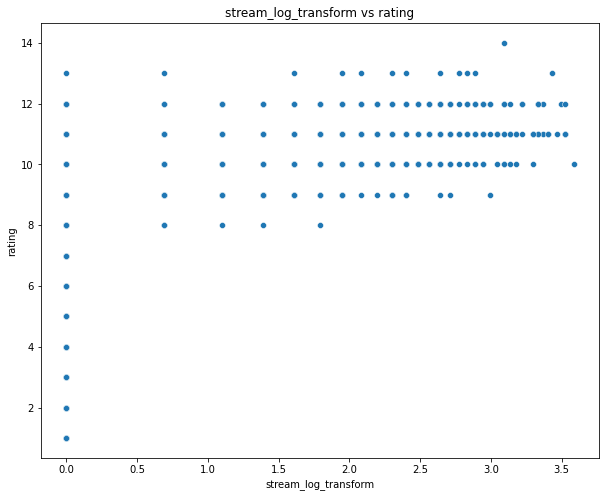

In [96]:
scatter_correlation(tech_df, 'stream_log_transform')

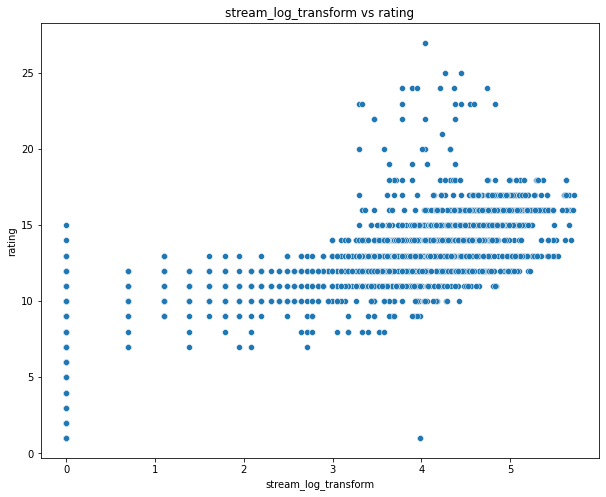

In [97]:
scatter_correlation(stam_df, 'stream_log_transform')

## Modeling 

### First Simple Model - Linear Regression with Scaled Data

### Tech Dataset

In [98]:
tech_data = tech_df.drop(columns = ['title', 'artist', 'difficulty', 'rating'], axis = 1)
tech_target = tech_df['rating']

In [99]:
#train test split and a split of the train set for validation

X_train_tech, X_test_tech, y_train_tech, y_test_tech = train_test_split(tech_data, tech_target, random_state = 42)
X_tr_tech, X_val_tech, y_tr_tech, y_val_tech = train_test_split(X_train_tech, y_train_tech, random_state = 42)

In [100]:
scaler = StandardScaler()
lr = LinearRegression()

X_tr_tech_scaled = scaler.fit_transform(X_tr_tech)
X_val_tech_scaled = scaler.transform(X_val_tech)

#scaling the full training set for cross validation
X_train_tech_scaled = scaler.transform(X_train_tech)

lr.fit(X_tr_tech_scaled, y_tr_tech)

LinearRegression()

In [101]:
print(f'LR | Train R^2: {lr.score(X_tr_tech_scaled, y_tr_tech)} \nLR | Val R^2: {lr.score(X_val_tech_scaled, y_val_tech)}')
print(f'LR | Train MSE: {mean_squared_error(y_tr_tech, lr.predict(X_tr_tech_scaled))} \nLR | Val MSE: {mean_squared_error(y_val_tech, lr.predict(X_val_tech_scaled))}')
print(f'Cross Validation: {cross_val_score(lr, X_train_tech_scaled, y_train_tech, scoring = 'r2')}')
print(f'Cross Validation Mean: {cross_val_score(lr, X_train_tech_scaled, y_train_tech, scoring = 'r2').mean()}')

LR | Train R^2: 0.9526777636299589 
LR | Test R^2: 0.9459640861156339
LR | Val MSE: 0.5879166268173216 
LR | Val MSE: 0.6228019322142858


The baseline cross-validation R-squared value is already rather high. Next steps will include tuning parameters.

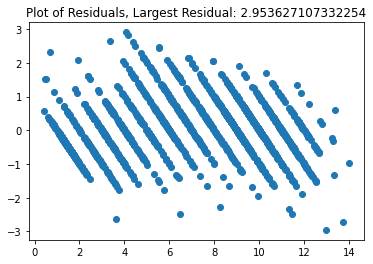

In [102]:
plot_resids(lr, X_tr_tech_scaled, y_tr_tech)

### Stamina Dataset

In [104]:
stam_data = stam_df.drop(columns = ['title', 'artist', 'difficulty', 'rating'], axis = 1)
stam_target = stam_df['rating']

#train test split twice to include a validation set
X_train_stam, X_test_stam, y_train_stam, y_test_stam = train_test_split(stam_data, stam_target, random_state = 42)
X_tr_stam, X_val_stam, y_tr_stam, y_val_stam = train_test_split(X_train_stam, y_train_stam, random_state = 42)

In [105]:
scaler = StandardScaler()
lr = LinearRegression()

X_tr_stam_scaled = scaler.fit_transform(X_tr_stam)
X_val_stam_scaled = scaler.transform(X_val_stam)

#scaling the full training set for cross validation
X_train_stam_scaled = scaler.transform(X_train_stam)

lr.fit(X_tr_stam_scaled, y_tr_stam)

LinearRegression()

In [106]:
print(f'LR | Train R^2: {lr.score(X_tr_stam_scaled, y_tr_stam)} \nLR | Val R^2: {lr.score(X_val_stam_scaled, y_val_stam)}')
print(f'LR | Train MSE: {mean_squared_error(y_tr_stam, lr.predict(X_tr_stam_scaled))} \nLR | Val MSE: {mean_squared_error(y_val_stam, lr.predict(X_val_stam_scaled))}')
print(f"Cross Validation: {cross_val_score(lr, X_train_stam_scaled, y_train_stam, scoring = 'r2')}")
print(f"Cross Validation Mean: {cross_val_score(lr, X_train_stam_scaled, y_train_stam, scoring = 'r2').mean()}")

LR | Train R^2: 0.960974737773495 
LR | Test R^2: 0.9655349659868745
LR | Val MSE: 0.5717719492333068 
LR | Val MSE: 0.5285784630303236


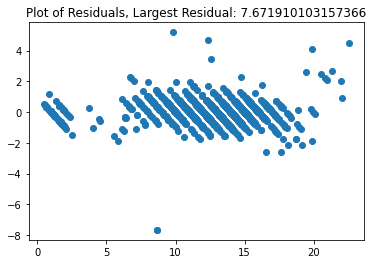

In [107]:
plot_resids(lr, X_tr_stam_scaled, y_tr_stam)

In [108]:
##looking for the outlier with the biggest residual:
preds = lr.predict(X_tr_stam_scaled)
resids = y_tr_stam - preds
max(abs(resids))

7.671910103157366

In [109]:
np.where(resids == -7.671910103157366)

(array([319, 435], dtype=int64),)

In [110]:
X_tr_stam.iloc[319]

song_seconds               200.000000
step_count                1184.000000
measure_count              115.000000
bpm_weighted_avg           138.000000
bpm_max                    138.000000
bpm_min                    138.000000
bpm_mode                   138.000000
bpm_change_count             0.000000
song_nps                     5.920000
nps_per_measure_max          9.200000
nps_per_measure_avg          5.920000
nps_per_measure_median       5.750000
nps_per_measure_std          3.454179
nps_per_measure_mode         9.200000
jumps                        6.000000
hands                        0.000000
quads                        0.000000
holds                       43.000000
mines                       55.000000
rolls                        0.000000
crossovers                 100.000000
footswitches                19.000000
crossover_footswitches      10.000000
jacks                        7.000000
invalid_crossovers           7.000000
stop_count                   0.000000
stream_total

In [111]:
stam_df.loc[stam_df['step_count'] == 1184]

,title,artist,song_seconds,step_count,measure_count,bpm_weighted_avg,bpm_max,bpm_min,bpm_mode,bpm_change_count,song_nps,nps_per_measure_max,nps_per_measure_avg,nps_per_measure_median,nps_per_measure_std,nps_per_measure_mode,jumps,hands,quads,holds,mines,rolls,crossovers,footswitches,crossover_footswitches,jacks,invalid_crossovers,stop_count,stream_total,stream_count,stream_size_max,stream_size_avg,stream_size_std,break_count,break_size_max,break_size_avg,break_total,break_size_std,difficulty,rating,stream_log_transform
13,Dragostea Din Tei,O-Zone,200.000000,1184.0,115.0,138.0,138.0,138.0,138.0,0.0,5.920000,9.2,5.920000,5.750,3.454179,9.2,6.0,0.0,0.0,43.0,55.0,0.0,10.0,19.0,9.0,7.0,7.0,0.0,54.0,8.0,7.0,6.750000,0.462910,9.0,18.0,6.777778,61.0,7.276293,Challenge,11.0,3.988984
14,Dragostea Din Tei,O-Zone,200.000000,1184.0,115.0,138.0,138.0,138.0,138.0,0.0,5.920000,9.2,5.920000,5.750,3.454179,9.2,6.0,0.0,0.0,43.0,55.0,0.0,100.0,19.0,10.0,7.0,7.0,0.0,54.0,8.0,7.0,6.750000,0.462910,9.0,18.0,6.777778,61.0,7.276293,Edit,1.0,3.988984
15,Dragostea Din Tei,O-Zone,200.000000,1184.0,115.0,138.0,138.0,138.0,138.0,0.0,5.920000,9.2,5.920000,5.750,3.454179,9.2,6.0,0.0,0.0,43.0,55.0,0.0,100.0,19.0,10.0,7.0,7.0,0.0,54.0,8.0,7.0,6.750000,0.462910,9.0,18.0,6.777778,61.0,7.276293,Edit,1.0,3.988984
365,Gott,Hommarju,119.384615,1184.0,97.0,195.0,195.0,195.0,195.0,0.0,9.917526,13.0,9.917526,13.000,4.454784,13.0,6.0,0.0,0.0,10.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,0.0,60.0,7.0,32.0,8.571429,11.530498,8.0,17.0,4.625000,37.0,5.289815,Challenge,15.0,4.094345
904,Bulletproof,La Roux,206.829268,1184.0,106.0,123.0,123.0,123.0,123.0,0.0,5.724528,8.2,5.724528,5.125,2.271658,8.2,0.0,0.0,0.0,30.0,0.0,1.0,8.0,14.0,7.0,5.0,12.0,0.0,42.0,3.0,16.0,14.000000,2.645751,4.0,25.0,16.000000,64.0,8.246211,Challenge,11.0,3.737670


The culprit is O-Zone's classic hit, [Dragostea Din Tei](https://www.youtube.com/watch?v=YnopHCL1Jk8).

### Iterations Upon First Simple Model

### Lasso Regression

In [170]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 1)
scaler = StandardScaler()

X_tr_tech_scaled = scaler.fit_transform(X_tr_tech)
X_val_tech_scaled = scaler.transform(X_val_tech)

lasso.fit(X_tr_tech, y_tr_tech)

print(f'LR | Train R^2: {lasso.score(X_tr_tech_scaled, y_tr_tech)} \nLR | Val R^2: {lasso.score(X_val_tech_scaled, y_val_tech)}')
print(f'LR | Train MSE: {mean_squared_error(y_tr_tech, lasso.predict(X_tr_tech_scaled))} \nLR | Val MSE: {mean_squared_error(y_val_tech, lasso.predict(X_val_tech_scaled))}')

LR | Train R^2: 0.9284527874748991 
LR | Test R^2: 0.9224708289957351
LR | Val MSE: 0.8888801348485971 
LR | Val MSE: 0.8935782525628393


While the Lasso regressor did not perform as well as the initial linear regression, it does help examine some potentially important features by looking at the coefficients.

In [171]:
lasso.coef_

array([-0.02067304,  0.01554017, -0.0194206 , -0.        ,  0.        ,
       -0.00134546, -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ,  0.0045707 ,  0.        ,  0.        ,
       -0.        , -0.        , -0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        ])

In [172]:
X_train_tech.columns

Index(['song_seconds', 'step_count', 'measure_count', 'bpm_weighted_avg',
       'bpm_max', 'bpm_min', 'bpm_mode', 'bpm_change_count', 'song_nps',
       'nps_per_measure_max', 'nps_per_measure_avg', 'nps_per_measure_median',
       'nps_per_measure_std', 'nps_per_measure_mode', 'jumps', 'hands',
       'quads', 'holds', 'mines', 'rolls', 'crossovers', 'footswitches',
       'crossover_footswitches', 'jacks', 'invalid_crossovers', 'stop_count',
       'stream_total', 'stream_log_transform'],
      dtype='object')

Potentially important coefficients to keep in mind:  
`song_seconds`  
`step_count`  
`measure_count`  
`bpm_min`  
`holds`

### Ridge Regression

In [132]:
from sklearn.linear_model import Ridge

ridge = Ridge()
scaler = StandardScaler()

X_val_tech_scaled = scaler.transform(X_val_tech)

Ridge()

In [134]:
#using GridSearchCV to optimize Ridge regression parameters:

ridge_params = {'alpha': [.1, .5, 1, 2, 5, 8],
                'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

ridge_grid = GridSearchCV(estimator = ridge, param_grid = ridge_params, scoring = 'r2')
#fitting to only scaled data
ridge_grid.fit(X_tr_tech_scaled, y_tr_tech)

ridge_grid.best_params_

#best parameter is low regularization alpha

{'alpha': 0.1, 'solver': 'svd'}

### Tech Dataset

In [135]:
##fitting a pipeline with scaling, power transform and a ridge regression with alpha = .1

ridge_pipe_tech = Pipeline([('scaler', StandardScaler()), 
                       ('power', PowerTransformer()), 
                       ('regressor', Ridge(alpha = .1, solver = 'svd'))])

ridge_pipe_tech.fit(X_tr_tech, y_tr_tech)

Pipeline(steps=[('scaler', StandardScaler()), ('power', PowerTransformer()),
                ('regressor', Ridge(alpha=0.1, solver='svd'))])

In [136]:
print(f'Ridge | Train R^2: {ridge_pipe_tech.score(X_tr_tech, y_tr_tech)} \nRidge | Val R^2: {ridge_pipe_tech.score(X_val_tech, y_val_tech)}')
print(f'Ridge | Train MSE: {mean_squared_error(y_tr_tech, ridge_pipe_tech.predict(X_tr_tech))} \nRidge | Val MSE: {mean_squared_error(y_val_tech, ridge_pipe_tech.predict(X_val_tech))}')
print(f"Cross Validation: {cross_val_score(ridge_pipe_tech, X_train_tech, y_train_tech, scoring = 'r2')}")
print(f"Cross Validation Mean: {cross_val_score(ridge_pipe_tech, X_train_tech, y_train_tech, scoring = 'r2').mean()}")

Ridge | Train R^2: 0.9607710151755463 
Ridge | Test R^2: 0.9534266406354278
Ridge | Val MSE: 0.4873686072465869 
Ridge | Val MSE: 0.5367907400259216


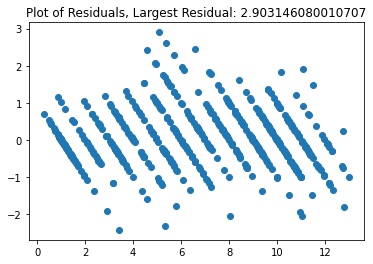

In [144]:
plot_resids(ridge_pipe_tech, X_val_tech, y_val_tech)

### Stamina Dataset

In [138]:
ridge_pipe_stam = Pipeline([('scaler', StandardScaler()), 
                       ('power', PowerTransformer()), 
                       ('regressor', Ridge(alpha = .1, solver = 'svd'))])

ridge_pipe_stam.fit(X_tr_stam, y_tr_stam)

Pipeline(steps=[('scaler', StandardScaler()), ('power', PowerTransformer()),
                ('regressor', Ridge(alpha=0.1, solver='svd'))])

In [139]:
print(f'Ridge | Train R^2: {ridge_pipe_stam.score(X_tr_stam, y_tr_stam)} \nRidge | Val R^2: {ridge_pipe_stam.score(X_val_stam, y_val_stam)}')
print(f'Ridge | Train MSE: {mean_squared_error(y_tr_stam, ridge_pipe_stam.predict(X_tr_stam))} \nRidge | Val MSE: {mean_squared_error(y_val_stam, ridge_pipe_stam.predict(X_val_stam))}')
print(f"Cross Validation: {cross_val_score(ridge_pipe_stam, X_train_stam, y_train_stam, scoring = 'r2')}")
print(f"Cross Validation Mean: {cross_val_score(ridge_pipe_stam, X_train_stam, y_train_stam, scoring = 'r2').mean()}")

Ridge | Train R^2: 0.9578520861237947 
Ridge | Test R^2: 0.9666890540102865
Ridge | Val MSE: 0.6175229453486666 
Ridge | Val MSE: 0.5108786089293678


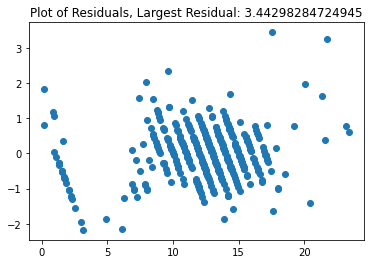

In [145]:
plot_resids(ridge_pipe_stam, X_val_stam, y_val_stam)

### Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNet

net = ElasticNet()
scaler = StandardScaler()

X_tr_tech_scaled = scaler.fit_transform(X_tr_tech)
X_val_tech_scaled = scaler.transform(X_val_tech)

net.fit(X_tr_tech_scaled, y_tr_tech)
net.score(X_val_tech_scaled, y_val)

The Elastic Net model has the lowest performance so far so we will not proceed.

Thus far, we have achieved an R-squared value of .9581 for the Tech dataset and .9579 for the Stamina dataset.
We will now try to introduce a categorical column.

### Categorical Features
Experimenting on the Tech dataset.

In [149]:
data = tech_df.drop(columns = ['title', 'difficulty', 'rating'], inplace = False)
target = tech_df['rating']

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42)

In [150]:
X_train_num = X_train.drop(columns = 'artist', inplace = False)
X_train_cat = X_train[['artist']]

In [151]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
X_train_enc = ohe.fit_transform(X_train_cat)

X_train_enc = pd.DataFrame(X_train_enc,
    columns=ohe.categories_[0],
    index=X_train.index
)

In [152]:
X_train_ = pd.concat([X_train_num, X_train_enc], axis = 1)

In [153]:
estimators = [('scaler', StandardScaler()), ('power_transformer', PowerTransformer()), ('regressor',Ridge(alpha = .1, solver = 'auto'))]
pipe = Pipeline(estimators)

pipe.fit(X_train_, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('power_transformer', PowerTransformer()),
                ('regressor', Ridge(alpha=0.1))])

In [159]:
import timeit
%timeit cross_val_score(pipe, X_train_, y_train)

KeyboardInterrupt: 

In [156]:
cross_val_score(pipe, X_train_, y_train).mean()

0.953703041796125

Generally good scores here, but slightly lowered performance and a considerable jump in computation time! This method does not seem to be fruitful.  
Back to numerical features only:  

In order to perform feature extraction with the Ridge Regressor, I have increased the regularization alpha in this iteration.

### Tech Dataset Feature Extraction

In [160]:
ridge_pipe_tech = Pipeline([('scaler', StandardScaler()), 
                       ('power', PowerTransformer()), 
                       ('regressor', Ridge(alpha = .3, solver = 'svd'))])

ridge_pipe_tech.fit(X_tr_tech, y_tr_tech)

Pipeline(steps=[('scaler', StandardScaler()), ('power', PowerTransformer()),
                ('regressor', Ridge(alpha=0.3, solver='svd'))])

In [162]:
print(f'Ridge | Train R^2: {ridge_pipe_tech.score(X_tr_tech, y_tr_tech)} \nRidge | Val R^2: {ridge_pipe_tech.score(X_val_tech, y_val_tech)}')
print(f'Ridge | Train MSE: {mean_squared_error(y_tr_tech, ridge_pipe_tech.predict(X_tr_tech))} \nRidge | Val MSE: {mean_squared_error(y_val_tech, ridge_pipe_tech.predict(X_val_tech))}')
print(f"Cross Validation: {cross_val_score(ridge_pipe_tech, X_train_tech, y_train_tech, scoring = 'r2')}")
print(f"Cross Validation Mean: {cross_val_score(ridge_pipe_tech, X_train_tech, y_train_tech, scoring = 'r2').mean()}")

Ridge | Train R^2: 0.9607571383891619 
Ridge | Test R^2: 0.9534965099853241
Ridge | Val MSE: 0.4875410080895735 
Ridge | Val MSE: 0.5359854466017907
Cross Validation: [0.95567609 0.96098265 0.95782158 0.95815162 0.95807056]
Cross Validation Mean: 0.9581404980404533


In [163]:
ridge_pipe_tech.steps[2][1].__dict__

{'alpha': 0.3,
 'fit_intercept': True,
 'normalize': False,
 'copy_X': True,
 'max_iter': None,
 'tol': 0.001,
 'solver': 'svd',
 'random_state': None,
 'n_features_in_': 28,
 'coef_': array([ 1.96262996e-01,  1.41938305e+00, -5.20079081e-01, -8.26888121e-03,
        -5.85405865e-02, -4.74256280e-02,  1.45039114e-01, -6.11472737e-02,
         3.27795504e+00,  8.34589870e-01, -2.53089815e+00, -1.82997196e-01,
         9.70059786e-01,  4.85324458e-02, -1.05232795e-01,  3.33195247e-02,
         7.26115736e-03,  8.52683404e-02, -2.44679720e-03, -6.12509087e-03,
        -2.05706435e-02,  1.91860230e-02,  7.46368462e-03,  1.69259580e-02,
         2.75264265e-02,  7.77618202e-02, -5.58652506e-01,  2.25386089e-01]),
 'n_iter_': None,
 'intercept_': 6.587362637362637}

In [164]:
X_train_tech.columns

Index(['song_seconds', 'step_count', 'measure_count', 'bpm_weighted_avg',
       'bpm_max', 'bpm_min', 'bpm_mode', 'bpm_change_count', 'song_nps',
       'nps_per_measure_max', 'nps_per_measure_avg', 'nps_per_measure_median',
       'nps_per_measure_std', 'nps_per_measure_mode', 'jumps', 'hands',
       'quads', 'holds', 'mines', 'rolls', 'crossovers', 'footswitches',
       'crossover_footswitches', 'jacks', 'invalid_crossovers', 'stop_count',
       'stream_total', 'stream_log_transform'],
      dtype='object')

The largest coefficients are indexed as:  
`1, 8, 10, 12`

corresponding to:  
`step_count`  
`song_nps`  
`nps_per_measure_max`  
`nps_per_measure_avg`  
`nps_per_measure_std`

Interestingly, the average NPS feature has a negative coefficient.

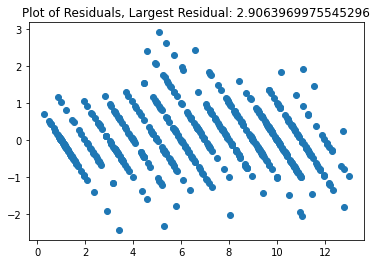

In [166]:
plot_resids(ridge_pipe_tech, X_val_tech, y_val_tech)

### Stamina Dataset Feature Extraction

In [165]:
ridge_pipe_stam = Pipeline([('scaler', StandardScaler()), 
                       ('power', PowerTransformer()), 
                       ('regressor', Ridge(alpha = .3, solver = 'svd'))])

ridge_pipe_stam.fit(X_tr_stam, y_tr_stam)

Pipeline(steps=[('scaler', StandardScaler()), ('power', PowerTransformer()),
                ('regressor', Ridge(alpha=0.3, solver='svd'))])

In [167]:
print(f'Ridge | Train R^2: {ridge_pipe_stam.score(X_tr_stam, y_tr_stam)} \nRidge | Val R^2: {ridge_pipe_stam.score(X_val_stam, y_val_stam)}')
print(f'Ridge | Train MSE: {mean_squared_error(y_tr_stam, ridge_pipe_stam.predict(X_tr_stam))} \nRidge | Val MSE: {mean_squared_error(y_val_stam, ridge_pipe_stam.predict(X_val_stam))}')
print(f"Cross Validation: {cross_val_score(ridge_pipe_stam, X_train_stam, y_train_stam, scoring = 'r2')}")
print(f"Cross Validation Mean: {cross_val_score(ridge_pipe_stam, X_train_stam, y_train_stam, scoring = 'r2').mean()}")

Ridge | Train R^2: 0.9578471368093978 
Ridge | Test R^2: 0.9667308947547331
Ridge | Val MSE: 0.6175954593813358 
Ridge | Val MSE: 0.510236911712901
Cross Validation: [0.94673336 0.94953823 0.97245229 0.95742932 0.96321398]
Cross Validation Mean: 0.9578734355807527


In [173]:
ridge_pipe_stam.steps[2][1].__dict__

{'alpha': 0.3,
 'fit_intercept': True,
 'normalize': False,
 'copy_X': True,
 'max_iter': None,
 'tol': 0.001,
 'solver': 'svd',
 'random_state': None,
 'n_features_in_': 37,
 'coef_': array([-0.03386983,  2.65929922, -1.01912707,  0.34295676, -0.19499663,
        -0.09624295, -0.0778057 ,  0.04531288,  0.74209704,  0.64508926,
         0.28559851, -0.16488751,  1.38482095, -0.05087844,  0.06150306,
         0.01265195,  0.01928842,  0.14148433, -0.08630006,  0.01212926,
         0.02127801,  0.07959846, -0.0702199 ,  0.02246034,  0.00941072,
        -0.03275971, -1.36273013,  0.33172793, -0.11170743,  0.08097701,
         0.16226201, -0.50208064,  0.05824576, -0.119762  , -0.09482414,
        -0.07409271,  0.45472829]),
 'n_iter_': None,
 'intercept_': 12.23561430793157}

In [174]:
X_train_stam.columns

Index(['song_seconds', 'step_count', 'measure_count', 'bpm_weighted_avg',
       'bpm_max', 'bpm_min', 'bpm_mode', 'bpm_change_count', 'song_nps',
       'nps_per_measure_max', 'nps_per_measure_avg', 'nps_per_measure_median',
       'nps_per_measure_std', 'nps_per_measure_mode', 'jumps', 'hands',
       'quads', 'holds', 'mines', 'rolls', 'crossovers', 'footswitches',
       'crossover_footswitches', 'jacks', 'invalid_crossovers', 'stop_count',
       'stream_total', 'stream_count', 'stream_size_max', 'stream_size_avg',
       'stream_size_std', 'break_count', 'break_size_max', 'break_size_avg',
       'break_total', 'break_size_std', 'stream_log_transform'],
      dtype='object')

Coefficients near or over abs(.75) are indexed as:  
`1, 2, 8, 12, 26`  
corresponding to:  
`step_count`  
`measure_count` - negative, possibly explained by the fact that longer songs may be less dense to account for difficulty   
`song_nps`    
`nps_per_measure_std`  
`stream_total`

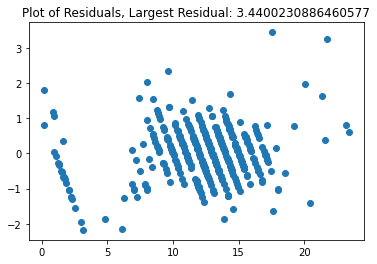

In [168]:
plot_resids(ridge_pipe_stam, X_val_stam, y_val_stam)

### Using the XGBoost Regressor 

### Tech Dataset

In [175]:
xgb_tech = Pipeline([('scaler', StandardScaler()), ('power', PowerTransformer()), ('xgb', XGBRegressor())])
xgb_stam = Pipeline([('scaler', StandardScaler()), ('power', PowerTransformer()), ('xgb', XGBRegressor())])

In [176]:
xgb_tech.fit(X_tr_tech, y_tr_tech)

Pipeline(steps=[('scaler', StandardScaler()), ('power', PowerTransformer()),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [177]:
print(f'XGB | Train R^2: {xgb_tech.score(X_tr_tech, y_tr_tech)} \nXGB | Val R^2: {xgb_tech.score(X_val_tech, y_val_tech)}')
print(f'XGB | Train MSE: {mean_squared_error(y_tr_tech, xgb_tech.predict(X_tr_tech))} \nXGB | Val MSE: {mean_squared_error(y_val_tech, xgb_tech.predict(X_val_tech))}')
print(f"Cross Validation: {cross_val_score(xgb_tech, X_train_tech, y_train_tech, scoring = 'r2')}")
print(f"Cross Validation Mean: {cross_val_score(xgb_tech, X_train_tech, y_train_tech, scoring = 'r2').mean()}")

XGB | Train R^2: 0.9997619255416259 
XGB | Test R^2: 0.9599635781899726
XGB | Val MSE: 0.002957762422810141 
XGB | Val MSE: 0.46144793471227735
Cross Validation: [0.960495   0.96147161 0.96080736 0.95509865 0.9606666 ]
Cross Validation Mean: 0.9597078442803534


### Stamina Dataset

In [178]:
xgb_stam.fit(X_tr_stam, y_tr_stam)

Pipeline(steps=[('scaler', StandardScaler()), ('power', PowerTransformer()),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=0, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [180]:
print(f'XGB | Train R^2: {xgb_stam.score(X_tr_stam, y_tr_stam)} \nXGB | Val R^2: {xgb_stam.score(X_val_stam, y_val_stam)}')
print(f'XGB | Train MSE: {mean_squared_error(y_tr_stam, xgb_stam.predict(X_tr_stam))} \nXGB | Val MSE: {mean_squared_error(y_val_stam, xgb_stam.predict(X_val_stam))}')
print(f"Cross Validation: {cross_val_score(xgb_stam, X_train_stam, y_train_stam, scoring = 'r2')}")
print(f"Cross Validation Mean: {cross_val_score(xgb_stam, X_train_stam, y_train_stam, scoring = 'r2').mean()}")

XGB | Train R^2: 0.9999299540954497 
XGB | Test R^2: 0.9784417003330427
XGB | Val MSE: 0.0010262655801796222 
XGB | Val MSE: 0.3306322836985369
Cross Validation: [0.97684662 0.97100758 0.97994062 0.97803492 0.97384831]
Cross Validation Mean: 0.9759356074701995


Using the XGBoost Regressor improved performance as well, with a bigger jump in the Stamina dataset than in Tech. The next step is to use GridsearchCV to search for more optimal hyperparameters.

### Tuning the Tech XGB Regressor

In [183]:
##Note: this code does take some time to execute, but the following cells will have optimal parameters if
##waiting is not an option
xgb_params = {
        'xgb__eta':[.7, .9, 1.1],
        'xgb__max_depth': [5, 10, 15, 20],
        'xgb__learning_rate': [0.001, 0.01, 0.1, .5, 1],
        'xgb__gamma': [0, 0.25, 0.5, 1.0],
        'xgb__reg_lambda': [0.1, 1.0, 5.0, 10.0],
        'xgb__n_estimators': [100, 120]
            }

tech_grid = GridSearchCV(estimator = xgb_tech, param_grid = xgb_params, scoring = 'r2')

tech_grid.fit(X_tr_tech, y_tr_tech)

KeyboardInterrupt: 

### Tuning the Stamina XGB Regressor

In [ ]:
xgb_params = {
        'xgb__eta':[.7, .9, 1.1],
        'xgb__max_depth': [5, 10, 15, 20],
        'xgb__learning_rate': [0.001, 0.01, 0.1, .5, 1],
        'xgb__gamma': [0, 0.25, 0.5, 1.0],
        'xgb__reg_lambda': [0.1, 1.0, 5.0, 10.0],
        'xgb__n_estimators': [100, 120]
            }

stam_grid = GridSearchCV(estimator = xgb_stam, param_grid = xgb_params, scoring = 'r2')

tech_grid.fit(X_tr_stam, y_tr_stam)

### Final Model

## Evaluation

### Metrics

### Visualization

## Summary / Conclusions

## Next Steps